# Data Analysis using __PySpark__  
*Fun with the __MovieLens__ dataset*  

**Part 3: Data Analysis basics using movies.csv from the MovieLens dataset**

<font color='green'>__Support for Google Colab__  </font>

<font color='green'>uncomment and execute the cell below to setup and run this Spark notebook on Google Colab.</font>

In [1]:
# # SETUP FOR COLAB: select all the lines below and uncomment (CTRL+/ on windows)

# # grab spark
# # as of 2023-06-23, the latest version is 3.4.1, get the link from Apache Spark's website
# ! wget -q https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
# # unzip spark
# !tar xf spark-3.4.1-bin-hadoop3.tgz
# # install findspark package
# !pip install -q findspark
# # Let's download and unzip the MovieLens 25M Dataset as well.
# ! mkdir ./../data
# ! wget -q https://files.grouplens.org/datasets/movielens/ml-25m.zip
# ! unzip ./ml-25m.zip -d ./../data/

# # got to provide JAVA_HOME and SPARK_HOME vairables
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# # IMPORTANT - UPDATE THE SPARK_HOME PATH BASED ON THE PACKAGE YOU DOWNLOAD
# os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"
# ! echo "DONE"

## Start the local/colab Spark Cluster

In [3]:
# Step 1: initialize findspark
import findspark

findspark.init()

# Step 2: import pyspark
import pyspark
from pyspark.sql import SparkSession

print(pyspark.__version__)

# Step 3: Create a spark session
#     using local[*] to use as many logical cores as available, use 1 when in doubt
#     'local[1]' indicates spark on 1 core on the local machine or specify the number of cores needed
#     use .config("spark.some.config.option", "some-value") for additional configuration

spark = (
    SparkSession.builder.master("local[*]")
    .appName("Analyzing Movielens Data")
    .getOrCreate()
)

# spark

3.5.0


# Problem Set 2  - ```movies.csv```

1. How many unique movies exist in the ```movies.csv``` dataset?  

1. Prepare a yearwise list of movies - Extract the year of release in movies.csv into a new column year_of_release   

1. List all unique genres found in ```movies.csv```, ordered lexically, case insensitive  

1. Prepare a genere wise list of movies - list all the movies for 'Crime', for 'Romance', and so on...  

1. Find number of films associated with each genre - add a new column to the movies dataframe: ```absolute_frequency_of_genre```  

1. Add another column ```num_genres``` and list total number of genres associated with each film  

1. Find out if a movie has both genres associated with it and also has ```(no genres listed)``` - if this is the case, find out how many such movies exist in the data set


# Load Movies data from the MovieLens dataset

In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

#
datalocation = "../data/ml-25m/"
file_path_movies = datalocation + "movies.csv"
file_path_links = datalocation + "links.csv"
#
schema_movies = StructType(
    [
        StructField("movieId", StringType(), False),
        StructField("title", StringType(), False),
        StructField("genres", StringType(), True),
    ]
)
#
schema_links = StructType(
    [
        StructField("movieId", StringType(), False),
        StructField("imdbId", StringType(), True),
        StructField("tmdbId", StringType(), True),
    ]
)
#
movies_raw = (
    spark.read.format("csv")
    .option("encoding", "UTF-8")
    .option("header", True)
    .option("sep", ",")
    .option("escape", '"')
    .schema(schema_movies)
    .load(file_path_movies)
)
#
links_raw = (
    spark.read.format("csv")
    .option("encoding", "UTF-8")
    .option("header", True)
    .option("sep", ",")
    .option("escape", '"')
    .schema(schema_links)
    .load(file_path_links)
)

In [5]:
movies_raw.show(10, False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

In [6]:
links_raw.show(10, False)

+-------+-------+------+
|movieId|imdbId |tmdbId|
+-------+-------+------+
|1      |0114709|862   |
|2      |0113497|8844  |
|3      |0113228|15602 |
|4      |0114885|31357 |
|5      |0113041|11862 |
|6      |0113277|949   |
|7      |0114319|11860 |
|8      |0112302|45325 |
|9      |0114576|9091  |
|10     |0113189|710   |
+-------+-------+------+
only showing top 10 rows



# Solutions to Problem Set 2

### How many unique movies exist in the movies.csv dataset?

In [7]:
# this is what the movies_raw data looks like:
movies_raw.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



Let's think about uniqueness 
* Do we look at ```movieId``` for uniqueness or ```title```?
* ```movieId``` sound like the right choice, as it'll keep the data consistent with tags, tag-relevance and ratings etc.
* *What could break here?* Let's try to articulate our assumptions and test them
* Can we assume that *primary keys mean unique movies*?
* Let's test that assumption, if it breaks, we'll know that our solutions must account for multiple ```movieId``` pointing to the same ```title```
* Following from above, can we assume that if the value in ```title``` matches for multiple ```movieId``` values then it's the same movie?
* Again, let's test this by building and reviewing the IMDB links

In [8]:
movies_with_matching_titles = (
    movies_raw.groupby(col("title")).count().filter(col("count") > 1)
)
movies_with_matching_titles.orderBy(col("count").desc()).show(12)
movies_with_matching_titles.count()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|     Casanova (2005)|    2|
|Another World (2014)|    2|
|     Believer (2018)|    2|
|         Eros (2004)|    2|
|Let There Be Ligh...|    2|
|    Slow Burn (2000)|    2|
|   Absolution (2015)|    2|
|     Paradise (2013)|    2|
|  The Promise (2016)|    2|
|        Reset (2017)|    2|
|The Midnight Man ...|    2|
|         Eden (2014)|    2|
+--------------------+-----+
only showing top 12 rows



98

In [9]:
movies_raw.filter(col("title") == "Casanova (2005)").show()

+-------+---------------+--------------------+
|movieId|          title|              genres|
+-------+---------------+--------------------+
|  42015|Casanova (2005)|Action|Adventure|...|
| 128862|Casanova (2005)|Comedy|Drama|Romance|
+-------+---------------+--------------------+



In [10]:
# links look different - use the links data for this bit
links_raw.filter(col("movieId") == "42015").show()
links_raw.filter(col("movieId") == "128862").show()

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|  42015|0402894|  9681|
+-------+-------+------+

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
| 128862|0427042|122023|
+-------+-------+------+



In [11]:
# Right join to work out movieIds for all the movies with matching titles
movies_with_multiple_title_matches = movies_raw.join(
    movies_with_matching_titles, "title", "right"
)

In [12]:
# compare the imdbId values for all movies with matching 'title' values in movies_raw
links_for_movies_with_multiple_title_matches = movies_with_multiple_title_matches.join(
    links_raw, "movieId", "left"
)

In [13]:
links_for_movies_with_multiple_title_matches.show(10)

+-------+--------------------+--------------------+-----+-------+------+
|movieId|               title|              genres|count| imdbId|tmdbId|
+-------+--------------------+--------------------+-----+-------+------+
| 128862|     Casanova (2005)|Comedy|Drama|Romance|    2|0427042|122023|
|  42015|     Casanova (2005)|Action|Adventure|...|    2|0402894|  9681|
| 156686|Another World (2014)|  (no genres listed)|    2|3500888|355925|
| 140633|Another World (2014)|         Documentary|    2|3326110|262897|
| 198947|     Believer (2018)|        Action|Crime|    2|7095654|518963|
| 190199|     Believer (2018)|         Documentary|    2|7689424|490001|
| 147002|         Eros (2004)|       Drama|Romance|    2|0343663| 39850|
|  32600|         Eros (2004)|               Drama|    2|0377059|  NULL|
| 191867|Let There Be Ligh...|         Documentary|    2|6184774|438442|
| 179783|Let There Be Ligh...|  (no genres listed)|    2|5804314|480881|
+-------+--------------------+--------------------+

In [14]:
# counts are all 1 - therefore all movies with matching titles still are unique movies
links_for_movies_with_multiple_title_matches.groupBy(col("imdbId")).count().orderBy(
    col("count").desc()
).show(5)

# conclusion: all movies in movies.csv are unique.

+--------+-----+
|  imdbId|count|
+--------+-----+
| 6306400|    1|
| 2463842|    1|
|10376068|    1|
| 0449040|    1|
| 0377059|    1|
+--------+-----+
only showing top 5 rows



In [15]:
# number of unique movies in movies.csv
movies_raw.distinct().count()

62423

The [site](https://grouplens.org/datasets/movielens/25m/) also reads:  

"MovieLens 25M movie ratings. Stable benchmark dataset. 25 million ratings and one million tag applications applied to 62,000 movies by 162,000 users. Includes tag genome data with 15 million relevance scores across 1,129 tags. Released 12/2019"

So we seem to be in the right ballpark here.  
Let's continue with our analysis.

### Extract the year of release in movies.csv into a new column year_of_release

In [16]:
# let's build a regex pattern to isolate the year of release
# this should be the last set of parenthesis in the title
# the regex needs a backslash to escape the parenthesis symbols, as these are used to identify groups
open_paren = "\\("
close_paren = "\\)"
# this should have only 4 digits between the parenthesis
year_pattern = "([0-9]{4})"
# the title should end with the closing parenthesis
close_paren = close_paren + "$"
# ignore whitespace
# keep unicode in mind
# global
# options_pattern = '/gxu'
# final pattern: the options_pattern thing is not supported in python
year_of_release_regex = open_paren + year_pattern + close_paren  # +options_pattern
print(year_of_release_regex)

\(([0-9]{4})\)$


In [17]:
# code cleanup update - all sql.functions imported at the top of this notebook
# from pyspark.sql.functions import regexp_extract

In [18]:
# our regex has 2 groups,
# 0 gives the first group match i.e. (1995)
# 1 gives the next group match i.e. 1995
movies_raw.withColumn(
    "year_of_release_0", regexp_extract(col("title"), year_of_release_regex, 0)
).withColumn(
    "year_of_release_1", regexp_extract(col("title"), year_of_release_regex, 1)
).show(
    10
)

+-------+--------------------+--------------------+-----------------+-----------------+
|movieId|               title|              genres|year_of_release_0|year_of_release_1|
+-------+--------------------+--------------------+-----------------+-----------------+
|      1|    Toy Story (1995)|Adventure|Animati...|           (1995)|             1995|
|      2|      Jumanji (1995)|Adventure|Childre...|           (1995)|             1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|           (1995)|             1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           (1995)|             1995|
|      5|Father of the Bri...|              Comedy|           (1995)|             1995|
|      6|         Heat (1995)|Action|Crime|Thri...|           (1995)|             1995|
|      7|      Sabrina (1995)|      Comedy|Romance|           (1995)|             1995|
|      8| Tom and Huck (1995)|  Adventure|Children|           (1995)|             1995|
|      9| Sudden Death (1995)|  

In [19]:
# so we'll use group 1 to create our dataframe
movies = movies_raw.withColumn(
    "year_of_release", regexp_extract(col("title"), year_of_release_regex, 1)
)

In [20]:
movies.show(10)

+-------+--------------------+--------------------+---------------+
|movieId|               title|              genres|year_of_release|
+-------+--------------------+--------------------+---------------+
|      1|    Toy Story (1995)|Adventure|Animati...|           1995|
|      2|      Jumanji (1995)|Adventure|Childre...|           1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|           1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           1995|
|      5|Father of the Bri...|              Comedy|           1995|
|      6|         Heat (1995)|Action|Crime|Thri...|           1995|
|      7|      Sabrina (1995)|      Comedy|Romance|           1995|
|      8| Tom and Huck (1995)|  Adventure|Children|           1995|
|      9| Sudden Death (1995)|              Action|           1995|
|     10|    GoldenEye (1995)|Action|Adventure|...|           1995|
+-------+--------------------+--------------------+---------------+
only showing top 10 rows



### List all unique genres found in movies.csv, ordered lexically, case insensitive

In [21]:
# code cleanup update - all sql.functions imported at the top of this notebook
# from pyspark.sql.functions import explode, split

In [22]:
# unique genres found in movies.csv
movie_genres = movies_raw.select(
    explode(  # convert each element in an array to a new row
        split(movies_raw.genres, "\|")  # split the data on pipe and create an arry
    ).alias("genre")
)

In [23]:
unique_movie_genres = movie_genres.distinct()
unique_movie_genres.show()

+------------------+
|             genre|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



### Find number of films associated with each genre - absolute_frequency_of_genre  

In [24]:
movie_genres_with_abs_freq = movie_genres.groupBy("genre").count()
movie_genres_with_abs_freq = movie_genres_with_abs_freq.orderBy(
    col("count").desc()
).withColumnRenamed("count", "absolute_frequency_of_genre")

movie_genres_with_abs_freq.show()
# TODO: rename the column 'count' to 'freq'

+------------------+---------------------------+
|             genre|absolute_frequency_of_genre|
+------------------+---------------------------+
|             Drama|                      25606|
|            Comedy|                      16870|
|          Thriller|                       8654|
|           Romance|                       7719|
|            Action|                       7348|
|            Horror|                       5989|
|       Documentary|                       5605|
|             Crime|                       5319|
|(no genres listed)|                       5062|
|         Adventure|                       4145|
|            Sci-Fi|                       3595|
|          Children|                       2935|
|         Animation|                       2929|
|           Mystery|                       2925|
|           Fantasy|                       2731|
|               War|                       1874|
|           Western|                       1399|
|           Musical|

In [25]:
# setup matplotlib before starting plotting
import matplotlib.pyplot as plt

# jupyter mpl magic
%matplotlib inline

# note: in case you want to use the widget or notebook magic:
# ensure that ipympl is also installed.
# there may be other steps involved as well
# for e.g. widget works based on nodeJS, so you'll have to config/enable that too

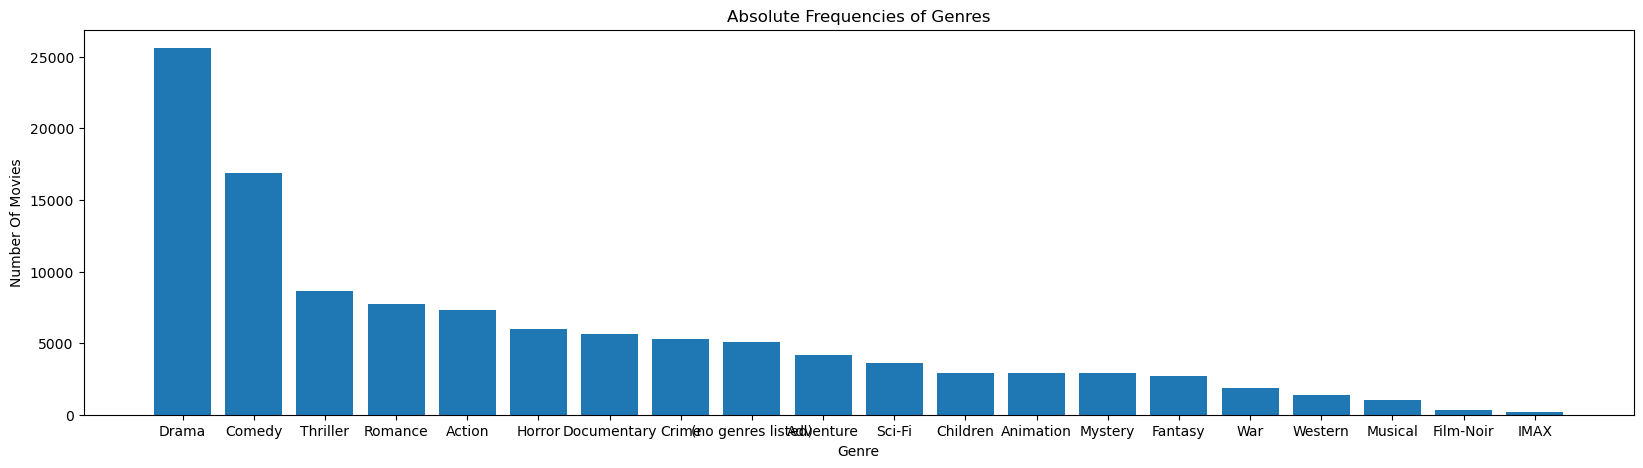

In [26]:
# convert each column to a list
movie_genres_with_abs_freq_x = (
    movie_genres_with_abs_freq.select(col("genre")).rdd.flatMap(lambda x: x).collect()
)
movie_genres_with_abs_freq_y = (
    movie_genres_with_abs_freq.select(col("absolute_frequency_of_genre"))
    .rdd.flatMap(lambda x: x)
    .collect()
)

plt.figure(figsize=(20, 5))
plt.bar(movie_genres_with_abs_freq_x, movie_genres_with_abs_freq_y)
plt.title("Absolute Frequencies of Genres")
plt.xlabel("Genre")
plt.ylabel("Number Of Movies")
plt.show()

### List total number of genres associated with each film

* Add another column num_genres and list total number of genres associated with each film

In [27]:
# like before we'll split the genres column on | and count the elements
# code cleanup update - all sql.functions imported at the top of this notebook
# from pyspark.sql.functions import size

movies = movies.withColumn("num_genres", size(split(col("genres"), "\|")))

In [28]:
movies.show(10, False)

+-------+----------------------------------+-------------------------------------------+---------------+----------+
|movieId|title                             |genres                                     |year_of_release|num_genres|
+-------+----------------------------------+-------------------------------------------+---------------+----------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|1995           |5         |
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |1995           |3         |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |1995           |2         |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |1995           |3         |
|5      |Father of the Bride Part II (1995)|Comedy                                     |1995           |1         |
|6      |Heat (1995)                       |Action|Crime|Thriller       

### Prepare a genere wise list of movies

* list all the movies for 'Crime', for 'Romance', and so on...

A naive appoach would be to filter movies for each genre that we know. This is doable as the number of genres we found is small. But it's not flexible and will need revision as new genres come to light. In practice, we may need something that's more dynamic.

In [29]:
romance = movies.where(col("genres").like("%Romance%"))
romance.show()

+-------+--------------------+--------------------+---------------+----------+
|movieId|               title|              genres|year_of_release|num_genres|
+-------+--------------------+--------------------+---------------+----------+
|      3|Grumpier Old Men ...|      Comedy|Romance|           1995|         2|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           1995|         3|
|      7|      Sabrina (1995)|      Comedy|Romance|           1995|         2|
|     11|American Presiden...|Comedy|Drama|Romance|           1995|         3|
|     15|Cutthroat Island ...|Action|Adventure|...|           1995|         3|
|     17|Sense and Sensibi...|       Drama|Romance|           1995|         2|
|     25|Leaving Las Vegas...|       Drama|Romance|           1995|         2|
|     28|   Persuasion (1995)|       Drama|Romance|           1995|         2|
|     33|Wings of Courage ...|Adventure|Romance...|           1995|         3|
|     35|   Carrington (1995)|       Drama|Romance| 

In [30]:
westerns = movies.where(col("genres").like("%Western%"))
westerns.show()

+-------+--------------------+--------------------+---------------+----------+
|movieId|               title|              genres|year_of_release|num_genres|
+-------+--------------------+--------------------+---------------+----------+
|    163|    Desperado (1995)|Action|Romance|We...|           1995|         3|
|    210|    Wild Bill (1995)|             Western|           1995|         1|
|    266|Legends of the Fa...|Drama|Romance|War...|           1994|         4|
|    303|Quick and the Dea...|Action|Thriller|W...|           1995|         3|
|    368|     Maverick (1994)|Adventure|Comedy|...|           1994|         3|
|    383|   Wyatt Earp (1994)|             Western|           1994|         1|
|    416|    Bad Girls (1994)|             Western|           1994|         1|
|    432|City Slickers II:...|Adventure|Comedy|...|           1994|         3|
|    458|Geronimo: An Amer...|       Drama|Western|           1993|         2|
|    487|Lightning Jack (1...|      Comedy|Western| 

In [31]:
no_genres_listed = movies.where(col("genres").like("%(no genres listed)%"))
no_genres_listed.show()
no_genres_listed.count()

+-------+--------------------+------------------+---------------+----------+
|movieId|               title|            genres|year_of_release|num_genres|
+-------+--------------------+------------------+---------------+----------+
|  83773|Away with Words (...|(no genres listed)|           1999|         1|
|  84768|   Glitterbug (1994)|(no genres listed)|           1994|         1|
|  86493|Age of the Earth,...|(no genres listed)|           1980|         1|
|  87061|Trails (Veredas) ...|(no genres listed)|           1978|         1|
|  91246|Milky Way (Tejút)...|(no genres listed)|           2007|         1|
|  92435|Dancing Hawk, The...|(no genres listed)|           1978|         1|
|  92641|Warsaw Bridge (Po...|(no genres listed)|           1990|         1|
|  94431|Ella Lola, a la T...|(no genres listed)|           1898|         1|
|  95750|Promise of the Fl...|(no genres listed)|           1975|         1|
|  96479|  Nocturno 29 (1968)|(no genres listed)|           1968|         1|

5062

Yeah...this is not a good approach.  

We want to be able to address as many generes as found in data, even though the list is available, it makes more sense to generate a list for all distinct values in the data

Can we create a column where there's only one 'genre' and the movie is duplicated as many times as the genre?

Spark Joins to the rescue.  

We'll create a ```full outer``` join (aka 'full' or 'outer') - resulting in each row in movies to be repeated once for each genere associated with it. If "127 Hours" has 3 genres "Adventure|Drama|Thriller" then it will now be in 3 rows, one each for "adventure", "drama" and "thriller".

In [32]:
movies_expanded_by_genre = movies.join(
    unique_movie_genres, col("genres").contains(col("genre")), "fullouter"
)
# movie_genres_with_abs_freq
movies_expanded_by_genre.orderBy(col("title")).show(25, True)

+-------+--------------------+--------------------+---------------+----------+-----------+
|movieId|               title|              genres|year_of_release|num_genres|      genre|
+-------+--------------------+--------------------+---------------+----------+-----------+
| 208297|"BLOW THE NIGHT!"...|   Documentary|Drama|           1983|         2|      Drama|
| 208297|"BLOW THE NIGHT!"...|   Documentary|Drama|           1983|         2|Documentary|
|  51372|"Great Performanc...|             Musical|           1998|         1|    Musical|
| 136604|#1 Cheerleader Ca...|        Comedy|Drama|           2010|         2|      Drama|
| 136604|#1 Cheerleader Ca...|        Comedy|Drama|           2010|         2|     Comedy|
| 183901|    #Captured (2017)|              Horror|           2017|         1|     Horror|
| 195955|#Female Pleasure ...|         Documentary|           2018|         1|Documentary|
| 203417|    #FollowMe (2019)|     Horror|Thriller|           2019|         2|   Thriller|

Now we can simply filter by genre from the same dataframe.

In [33]:
romance1 = movies_expanded_by_genre.filter(col("genre") == "Romance")
romance1.show()

+-------+--------------------+--------------------+---------------+----------+-------+
|movieId|               title|              genres|year_of_release|num_genres|  genre|
+-------+--------------------+--------------------+---------------+----------+-------+
|      3|Grumpier Old Men ...|      Comedy|Romance|           1995|         2|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|           1995|         3|Romance|
|      7|      Sabrina (1995)|      Comedy|Romance|           1995|         2|Romance|
|     11|American Presiden...|Comedy|Drama|Romance|           1995|         3|Romance|
|     15|Cutthroat Island ...|Action|Adventure|...|           1995|         3|Romance|
|     17|Sense and Sensibi...|       Drama|Romance|           1995|         2|Romance|
|     25|Leaving Las Vegas...|       Drama|Romance|           1995|         2|Romance|
|     28|   Persuasion (1995)|       Drama|Romance|           1995|         2|Romance|
|     33|Wings of Courage ...|Adventure|Rom

So ```movies_expanded_by_genre``` is it.

### Find out if a movie has both genres associated with it and also has ```(no genres listed)```  

* if this is the case, find out how many such movies exist in the data set

In [34]:
# filter out the movies with (no genres listed)
# where and filter, like and contains - use what is most readable
# also remove the %xxx% for contains...

# 1
# movies.where(col('genres').contains('no genres')).show()

# 2
# movies.where(col('genres').like('%no genres%')).show()

# 3
# movies.filter(col('genres').like('%no genres%')).show()

# 4
movies.filter(col("genres").contains("no genres")).show(10)

+-------+--------------------+------------------+---------------+----------+
|movieId|               title|            genres|year_of_release|num_genres|
+-------+--------------------+------------------+---------------+----------+
|  83773|Away with Words (...|(no genres listed)|           1999|         1|
|  84768|   Glitterbug (1994)|(no genres listed)|           1994|         1|
|  86493|Age of the Earth,...|(no genres listed)|           1980|         1|
|  87061|Trails (Veredas) ...|(no genres listed)|           1978|         1|
|  91246|Milky Way (Tejút)...|(no genres listed)|           2007|         1|
|  92435|Dancing Hawk, The...|(no genres listed)|           1978|         1|
|  92641|Warsaw Bridge (Po...|(no genres listed)|           1990|         1|
|  94431|Ella Lola, a la T...|(no genres listed)|           1898|         1|
|  95750|Promise of the Fl...|(no genres listed)|           1975|         1|
|  96479|  Nocturno 29 (1968)|(no genres listed)|           1968|         1|

In [35]:
# number of records where num_genres is more than 1 for (no genres listed)
movies.filter(col("genres").contains("no genres")).filter(col("num_genres") > 1).count()

0

In [36]:
# alternatively list num_genres in descending order
movies.filter(col("genres").contains("no genres")).orderBy(
    col("num_genres").desc()
).show(10)

+-------+--------------------+------------------+---------------+----------+
|movieId|               title|            genres|year_of_release|num_genres|
+-------+--------------------+------------------+---------------+----------+
|  83773|Away with Words (...|(no genres listed)|           1999|         1|
|  84768|   Glitterbug (1994)|(no genres listed)|           1994|         1|
|  86493|Age of the Earth,...|(no genres listed)|           1980|         1|
|  87061|Trails (Veredas) ...|(no genres listed)|           1978|         1|
|  91246|Milky Way (Tejút)...|(no genres listed)|           2007|         1|
|  92435|Dancing Hawk, The...|(no genres listed)|           1978|         1|
|  92641|Warsaw Bridge (Po...|(no genres listed)|           1990|         1|
|  94431|Ella Lola, a la T...|(no genres listed)|           1898|         1|
|  95750|Promise of the Fl...|(no genres listed)|           1975|         1|
|  96479|  Nocturno 29 (1968)|(no genres listed)|           1968|         1|

So there's no movies where ```(no genres listed)``` is mixed with other genres.

# Clear cache and stop the spark cluster

In [37]:
# clear cache
spark.catalog.clearCache()

In [38]:
# stop spark
spark.stop()

# Insights

What have we learned from working on Problem Set 2?

1. Regex based matching, pay attention to the regex group you want to extract
1. Explode (convert array in the column value into rows) and Split (convert string into array based on a token)
1. size() is the pySpark equivalent of len(array)
	* There's like 4 of these that you should [familiarize yourself](https://sparkbyexamples.com/pyspark/pyspark-explode-array-and-map-columns-to-rows/) with: ```explode()```, ```explore_outer()```, ```posexplode()```, ```posexplode_outer()```
1. That DataFrame>Select>RDD>FlatMap>Collect thing for creating lists out of dataframe columns for plotting etc. - it's just tedious, so try to remember it
1. [joi](https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/).[ns](https://github.com/spark-examples/pyspark-examples/blob/master/pyspark-join-two-dataframes.py), [joins](https://www.geeksforgeeks.org/pyspark-join-types-join-two-dataframes/), [joins](https://dzone.com/articles/pyspark-join-explained-with-examples), [can't get](https://medium.com/@achilleus/https-medium-com-joins-in-apache-spark-part-1-ce289bfc84c9) [enough](https://medium.com/@achilleus/https-medium-com-joins-in-apache-spark-part-2-5b038bc7455b) of 'em. 
1. Also, ```crossJoin``` when you need a cartesian product (cross product) and have no conditions. 
    * Spark >= 3.0. ```spark.sql.crossJoin.enable``` is ```True``` by default, if not, you'll need to ```SparkSession.config("spark.sql.crossJoin.enable",True)```
1. ```where``` and ```filter```, ```like``` and ```contains```

# Next

We continue our data analysis exercises with the ratings.csv data.